# Bitcoin price predictor using RNN

## Load data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random
random.seed(123)
import seaborn as sns
import datetime
from datetime import date
import yfinance as yf

In [2]:
########## DOWNLOAD DATA DIRECTLY FROM YAHOO FINANCE ##########

stocks = ['BTC-USD','GOOG','GC=F','TSLA'] ## add featues here
end = datetime.date.today()
start = datetime.datetime(2019,1,2)
stock_prices = yf.download(stocks,start=start,end = end, interval='1d')

[*********************100%***********************]  4 of 4 completed


In [3]:
raw_df = stock_prices
raw_df.head(2)

Adj Close                                             Close  \
                BTC-USD         GC=F         GOOG       TSLA      BTC-USD   
Date                                                                        
2019-01-02  3943.409424  1281.000000  1045.849976  62.023998  3943.409424   
2019-01-03  3836.741211  1291.800049  1016.059998  60.071999  3836.741211   

                                                        High          ...  \
                   GC=F         GOOG       TSLA      BTC-USD    GC=F  ...   
Date                                                                  ...   
2019-01-02  1281.000000  1045.849976  62.023998  3947.981201  1286.0  ...   
2019-01-03  1291.800049  1016.059998  60.071999  3935.685059  1292.0  ...   

                    Low                    Open                            \
                   GOOG       TSLA      BTC-USD         GC=F         GOOG   
Date                                                                        
2019-01-02  1015.710022  59.759998  3849.216309  1286.000000  1016.570007   
2019-01-03  1014.070007  59.476002  3931.048584  1286.800049  1041.000000   

                           Volume                                
                 TSLA     BTC-USD   GC=F       GOOG        TSLA  
Date                                                             
2019-01-02  61.220001  5244856835  149.0  1532600.0  58293000.0  
2019-01-03  61.400002  4530215218   10.0  1841100.0  34826000.0  

[2 rows x 24 columns]

In [4]:
raw_df['Date'] =  raw_df.index

In [5]:
raw_df['Date'] = pd.to_datetime(raw_df['Date'])

In [6]:
raw_df.head(2)

Adj Close                                             Close  \
                BTC-USD         GC=F         GOOG       TSLA      BTC-USD   
Date                                                                        
2019-01-02  3943.409424  1281.000000  1045.849976  62.023998  3943.409424   
2019-01-03  3836.741211  1291.800049  1016.059998  60.071999  3836.741211   

                                                        High          ...  \
                   GC=F         GOOG       TSLA      BTC-USD    GC=F  ...   
Date                                                                  ...   
2019-01-02  1281.000000  1045.849976  62.023998  3947.981201  1286.0  ...   
2019-01-03  1291.800049  1016.059998  60.071999  3935.685059  1292.0  ...   

                  Low         Open                                       \
                 TSLA      BTC-USD         GC=F         GOOG       TSLA   
Date                                                                      
2019-01-02  59.759998  3849.216309  1286.000000  1016.570007  61.220001   
2019-01-03  59.476002  3931.048584  1286.800049  1041.000000  61.400002   

                Volume                                     Date  
               BTC-USD   GC=F       GOOG        TSLA             
Date                                                             
2019-01-02  5244856835  149.0  1532600.0  58293000.0 2019-01-02  
2019-01-03  4530215218   10.0  1841100.0  34826000.0 2019-01-03  

[2 rows x 25 columns]

## Exploratory analysis

/Users/pedro/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


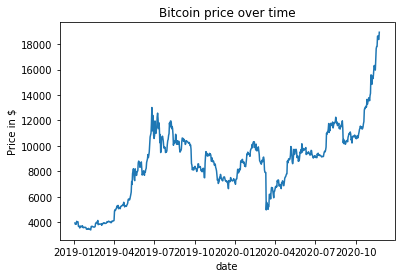

In [7]:
data = raw_df['Close']['BTC-USD']
plt.plot(data)

plt.title('Bitcoin price over time')
plt.xlabel('date')
plt.ylabel('Price in $')
plt.show()

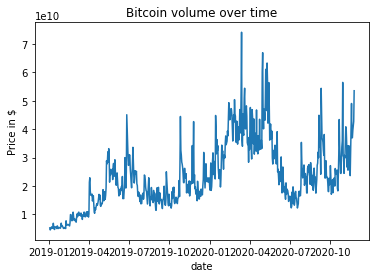

In [8]:
data = raw_df['Volume']['BTC-USD']
plt.plot(data)

plt.title('Bitcoin volume over time')
plt.xlabel('date')
plt.ylabel('Price in $')
plt.show()

## formatting data - from yahoo finance

In [9]:
def get_data(indices,keys):
    a =[(key,index) for key in keys for index in indices]
    return raw_df[a]

In [10]:
####### INCLUDE NEW FEATURES HERE ####### 
df = get_data(['BTC-USD','GOOG','GC=F','TSLA'],['Close','Volume'])

In [11]:
df.head(2)

Close                                           Volume  \
                BTC-USD         GOOG         GC=F       TSLA     BTC-USD   
Date                                                                       
2019-01-02  3943.409424  1045.849976  1281.000000  62.023998  5244856835   
2019-01-03  3836.741211  1016.059998  1291.800049  60.071999  4530215218   

                                          
                 GOOG   GC=F        TSLA  
Date                                      
2019-01-02  1532600.0  149.0  58293000.0  
2019-01-03  1841100.0   10.0  34826000.0

## Data preprossesing

### getting rid of NaNs

In [12]:
df = df.fillna(method='ffill')

### calculating percentage change of btc_price

In [13]:
df['percentage_change_price'] = df['Close']['BTC-USD'].pct_change()

In [14]:
df.head(2)

Close                                           Volume  \
                BTC-USD         GOOG         GC=F       TSLA     BTC-USD   
Date                                                                       
2019-01-02  3943.409424  1045.849976  1281.000000  62.023998  5244856835   
2019-01-03  3836.741211  1016.059998  1291.800049  60.071999  4530215218   

                                         percentage_change_price  
                 GOOG   GC=F        TSLA                          
Date                                                              
2019-01-02  1532600.0  149.0  58293000.0                     NaN  
2019-01-03  1841100.0   10.0  34826000.0                -0.02705

In [15]:
####### CHECK UNBALANCED DATA SET ########
(df['percentage_change_price']>0).value_counts()

True     371
False    322
Name: percentage_change_price, dtype: int64

## Transform Date

In [16]:
df.columns

MultiIndex(levels=[['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'Date', 'percentage_change_price'], ['BTC-USD', 'GC=F', 'GOOG', 'TSLA', '']],
           codes=[[1, 1, 1, 1, 5, 5, 5, 5, 7], [0, 2, 1, 3, 0, 2, 1, 3, 4]])

In [17]:
new_colum_names = []
for el1, el2 in df.columns:
    new_colum_names.append(el1 + "_" + el2)
new_colum_names

['Close_BTC-USD',
 'Close_GOOG',
 'Close_GC=F',
 'Close_TSLA',
 'Volume_BTC-USD',
 'Volume_GOOG',
 'Volume_GC=F',
 'Volume_TSLA',
 'percentage_change_price_']

In [18]:
df.columns = new_colum_names

In [19]:
df['Date'] = df.index

In [20]:
df['Date'] = pd.to_datetime(df['Date'])
df['month'] = df['Date'].dt.month

df['year'] = df['Date'].dt.year

In [21]:
# Define percentage change in price column
df['delta_binary'] = df.percentage_change_price_>0
df['delta_binary'] = df['delta_binary'].astype(int)
df.head(2)

,Close_BTC-USD,Close_GOOG,Close_GC=F,Close_TSLA,Volume_BTC-USD,Volume_GOOG,Volume_GC=F,Volume_TSLA,percentage_change_price_,Date,month,year,delta_binary
Date,,,,,,,,,,,,,
2019-01-02,3943.409424,1045.849976,1281.000000,62.023998,5244856835,1532600.0,149.0,58293000.0,NaN,2019-01-02,1,2019,0
2019-01-03,3836.741211,1016.059998,1291.800049,60.071999,4530215218,1841100.0,10.0,34826000.0,-0.02705,2019-01-03,1,2019,0


In [23]:
df[['percentage_change_price_','delta_binary']].head(5)

,percentage_change_price_,delta_binary
Date,,
2019-01-02,NaN,0
2019-01-03,-0.027050,0
2019-01-04,0.005467,1
2019-01-05,-0.003246,0
2019-01-06,0.060189,1


In [23]:
scaled_names = df.columns[:-1]
scaled_names

Index(['Close_BTC-USD', 'Close_GOOG', 'Close_GC=F', 'Close_TSLA',
       'Volume_BTC-USD', 'Volume_GOOG', 'Volume_GC=F', 'Volume_TSLA',
       'percentage_change_price_', 'Date', 'month', 'year'],
      dtype='object')

## Data Sampling

- Out of this very long time-series, we will subsample it into shorter samples, each corresponding to one sequence of data  𝑋𝑖  with its corresponding prediction  𝑦𝑖 .
- get_sample -> function to get this random sample

Note:
  
  - **length** corresponds to the lenght of the observed sequence
  - **temporal_horizon** corresponds to the number of days between your last seen stock market value and the day you are trying to predict. -> in our case we want to predict for now the day after so tempor_horizon =1

In [24]:
df.shape

(692, 13)

In [25]:
import numpy as np

def get_sample(df, length, temporal_horizon):
    
    features = [col_name for col_name in df.columns if col_name not in {'Date', 'Close_BTC-USD','delta_binary',
                                                                        'percentage_change_price_'} ]
    
    temporal_horizon = temporal_horizon - 1
    last_possible = df.shape[0] - temporal_horizon - length

    random_start = np.random.randint(0, last_possible)
    X_sample = df[features].iloc[random_start: random_start+length].values ## we need to say which features we are using??!
    y_sample = df['delta_binary'].iloc[random_start+length+temporal_horizon]
    y_before = df['delta_binary'].iloc[random_start+length+temporal_horizon-1]
   
    return X_sample, y_sample, y_before

In [26]:
get_sample(df,1,1)

(array([[1.23367004e+03, 1.71050000e+03, 1.53824005e+02, 3.31879599e+10,
         2.95130000e+06, 1.25500000e+03, 1.52220000e+07, 4.00000000e+00,
         2.02000000e+03]]),
 1,
 1)

For instance, get_sample(df, 10, 3) returns a first list of **10 stock market values**, and a second value which is the stock market value 3 days after the last seen value.

## Dataset construction

The previous function creates a sample (𝑋𝑖,𝑦𝑖) . If we repeat this operation, we will get multiple samples, that once concatenated will correspond to our entire dataset (𝑋,𝑦) .

Create a function get_X_y(data, temporal_horizon, length_of_sequences) that create this dataset.

- data corresponds to your input data
- temporal_horizon is the number of days between the last seen value and the predicted one
- length_of_sequences is a list that corresponds to the length of each sample 𝑋𝑖 : [len(X_1), len(X_2), len(X_3), ..., ] as that each sequence 𝑋𝑖 has no reason to be of the same length as the other one.

Hint: This function should use get_sample

In [27]:
# create a matrix
def get_X_y(df, temporal_horizon, length_of_sequences):
    X, y, y_before = [], [], []

    for len_ in length_of_sequences:
        xi, yi, y_bi = get_sample(df, len_, temporal_horizon)
        X.append(xi)
        y.append(yi)
        y_before.append(y_bi)
        
    return X, np.array(y), np.array(y_before)

 - Write a function given a dataframe, a temporal horizon and a list of sequence length outputs the padded train and test set.
 - To have a batch_size larger than one, we need to **pad** our data_ purely engineering reason
 

In [28]:
from sklearn.model_selection import train_test_split

def generate_data(df_train, df_test, temporal_horizon, min_len, max_len):
      
    length_of_sequences_train = np.random.randint(min_len, max_len, len(df_train)) 
    length_of_sequences_test = np.random.randint(min_len, max_len, len(df_test))
    
    # Train 
    X_train, y_train, y_b_train = get_X_y(df_train, temporal_horizon, length_of_sequences_train)
    X_train = pad_sequences(X_train, padding='post', dtype='float32')
   
    # Test
    X_test, y_test, y_b_test = get_X_y(df_test, temporal_horizon, length_of_sequences_test)
    X_test = pad_sequences(X_test, padding='post', dtype='float32')
    
    return X_train, X_test, y_train, y_test, y_b_test, y_b_train

- Generate data with a temporal horizon of 1 days, and 100 time-series of 10 to 10 seen days .

## Split data

In [29]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Splitting 80/20
start = 1 # do a for loop
index = round((len(df)-start)*.8)

# Past
df_train = df.iloc[start:index+start]

#Future
df_test = df.iloc[start+index:]


temporal_horizon = 1 # -> predict the day after
min_len = 20
max_len = 30
#(group 10 days,group of 20 days , # observations each time)


In [30]:
#df.head(2)

In [31]:
df_test = df_test.drop(columns = 'Date')
df = df.drop(columns = ['Date'])

In [32]:
df_train = df_train.drop(columns = 'Date')

In [33]:
df_test.dtypes

Close_BTC-USD               float64
Close_GOOG                  float64
Close_GC=F                  float64
Close_TSLA                  float64
Volume_BTC-USD                int64
Volume_GOOG                 float64
Volume_GC=F                 float64
Volume_TSLA                 float64
percentage_change_price_    float64
month                         int64
year                          int64
delta_binary                  int64
dtype: object

## Feature scaling

##### Fetaure scaling: only on train data ######

In [34]:
df.columns

Index(['Close_BTC-USD', 'Close_GOOG', 'Close_GC=F', 'Close_TSLA',
       'Volume_BTC-USD', 'Volume_GOOG', 'Volume_GC=F', 'Volume_TSLA',
       'percentage_change_price_', 'month', 'year', 'delta_binary'],
      dtype='object')

In [35]:
df_test.shape,df_train.shape

((138, 12), (553, 12))

In [36]:
# Scaling: MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

#features_list = [col_name for col_name in df.columns if col_name not in {'Date', 'Close'} ]

# normalizing features
normalizer_features = MinMaxScaler()
normalizer_features.fit(df_train)
scaled_df = pd.DataFrame(normalizer_features.transform(df))

# mormalizing output/target
#normalizer_output = MinMaxScaler()
#normalizer_output.fit(df_train[['percentage_change_price']])
#scaled_df['percentage_change_price'] = normalizer_output.transform(df[['percentage_change_price']])
scaled_df['delta_binary'] = df.reset_index()[['delta_binary']]

# not normalizing, uncomment this
# scaled_df = df

/Users/pedro/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [37]:
scaled_df['delta_binary']

0      0
1      0
2      1
3      0
4      1
5      0
6      1
7      1
8      0
9      1
10     0
11     0
12     1
13     0
14     1
15     1
16     0
17     1
18     0
19     0
20     1
21     0
22     1
23     0
24     1
25     0
26     0
27     0
28     1
29     0
      ..
662    0
663    1
664    1
665    0
666    1
667    1
668    1
669    0
670    0
671    1
672    1
673    1
674    0
675    0
676    1
677    0
678    0
679    1
680    1
681    1
682    0
683    0
684    1
685    1
686    1
687    1
688    1
689    1
690    0
691    0
Name: delta_binary, Length: 692, dtype: int64

In [38]:
scaled_df.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,delta_binary
0,0.056561,0.05834,0.021421,0.108309,0.010264,0.202253,0.000046,0.171440,NaN,0.0,0.0,0.0,0
1,0.045470,0.00000,0.041194,0.100249,0.000000,0.254902,0.000003,0.092529,0.622584,0.0,0.0,0.0,0


## Generate data sequences

In [39]:
scaled_df.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,delta_binary
0,0.056561,0.05834,0.021421,0.108309,0.010264,0.202253,0.000046,0.17144,NaN,0.0,0.0,0.0,0


In [40]:
scaled_df_train, scaled_df_test = scaled_df.iloc[start:(index+start)], scaled_df.iloc[start+index:]

In [41]:
X_train, X_test, y_train, y_test, y_b_test, y_b_train = generate_data(scaled_df_train,
                                                    scaled_df_test, temporal_horizon, min_len, max_len)

In [42]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(y_b_train.shape)
print(y_b_test.shape)

(553, 29, 12)
(138, 29, 12)
(553,)
(138,)
(553,)
(138,)


In [43]:
X_train

array([[[0.0734065 , 0.30795306, 0.0501646 , ..., 0.18181819,
         0.        , 0.        ],
        [0.0788947 , 0.34931374, 0.03496883, ..., 0.27272728,
         0.        , 1.        ],
        [0.15394023, 0.36118132, 0.03789812, ..., 0.27272728,
         0.        , 1.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.53565747, 0.62434644, 0.3625046 , ..., 0.90909094,
         0.        , 1.        ],
        [0.5384874 , 0.62434644, 0.3676308 , ..., 0.90909094,
         0.        , 1.        ],
        [0.5105477 , 0.59659636, 0.36909556, ..., 0.90909094,
         0.        , 0.        ],
        ...,
        [0.39968374, 0.6545053 , 0.36140594, ..., 1.        ,
         0.        , 1.        ],
        [0. 

## Baseline model: LSTM with feature scaling 

- LSTM: Introduced to prevent the vanishing gradient: for **long** time-series, the gradient (of the backpropagation, during the optimizer updates) vanished to 0.

In [80]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

def init_model():

    model = Sequential()
    model.add(layers.Masking())
    model.add(layers.LSTM(10, activation='tanh'))
    model.add(layers.Dense(15, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop', 
                  metrics=['accuracy'])# find loss an penalizing negative or positive results - alternatives to mae
                                  # mae weighted
    return model


In [81]:
# Fit the model
from tensorflow.keras.callbacks import EarlyStopping

model = init_model()

es = EarlyStopping(patience=20, mode='min', verbose=0, monitor='val_loss',restore_best_weights=True)
# patience = 30 - > if my algorithm doesnt improve my performance for a certain number of iterations 
# (patience) stop the fitting process, return the weights as they are

history = model.fit(X_train,y_train,
          batch_size=16,
          epochs=1000, # iteration through your data
          validation_split=0.3,
          callbacks=[es],
          verbose=2)

Epoch 1/1000
25/25 - 1s - loss: 0.6983 - accuracy: 0.4832 - val_loss: 0.6975 - val_accuracy: 0.4940
Epoch 2/1000
25/25 - 0s - loss: 0.6950 - accuracy: 0.5168 - val_loss: 0.6956 - val_accuracy: 0.4639
Epoch 3/1000
25/25 - 0s - loss: 0.6943 - accuracy: 0.4987 - val_loss: 0.6941 - val_accuracy: 0.4880
Epoch 4/1000
25/25 - 0s - loss: 0.6941 - accuracy: 0.4910 - val_loss: 0.6945 - val_accuracy: 0.4940
Epoch 5/1000
25/25 - 0s - loss: 0.6939 - accuracy: 0.5194 - val_loss: 0.6934 - val_accuracy: 0.4940
Epoch 6/1000
25/25 - 0s - loss: 0.6935 - accuracy: 0.4832 - val_loss: 0.6925 - val_accuracy: 0.4819
Epoch 7/1000
25/25 - 0s - loss: 0.6935 - accuracy: 0.4884 - val_loss: 0.6926 - val_accuracy: 0.4880
Epoch 8/1000
25/25 - 0s - loss: 0.6933 - accuracy: 0.5013 - val_loss: 0.6922 - val_accuracy: 0.4819
Epoch 9/1000
25/25 - 0s - loss: 0.6929 - accuracy: 0.4806 - val_loss: 0.6919 - val_accuracy: 0.4940
Epoch 10/1000
25/25 - 0s - loss: 0.6928 - accuracy: 0.4832 - val_loss: 0.6915 - val_accuracy: 0.4940

Epoch 83/1000
25/25 - 0s - loss: 0.6475 - accuracy: 0.5995 - val_loss: 0.6734 - val_accuracy: 0.5602
Epoch 84/1000
25/25 - 0s - loss: 0.6404 - accuracy: 0.6150 - val_loss: 0.6738 - val_accuracy: 0.5663
Epoch 85/1000
25/25 - 0s - loss: 0.6458 - accuracy: 0.5762 - val_loss: 0.6824 - val_accuracy: 0.5663
Epoch 86/1000
25/25 - 0s - loss: 0.6493 - accuracy: 0.5866 - val_loss: 0.6822 - val_accuracy: 0.5663
Epoch 87/1000
25/25 - 0s - loss: 0.6455 - accuracy: 0.6047 - val_loss: 0.6824 - val_accuracy: 0.5723
Epoch 88/1000
25/25 - 0s - loss: 0.6430 - accuracy: 0.5917 - val_loss: 0.6778 - val_accuracy: 0.5602
Epoch 89/1000
25/25 - 0s - loss: 0.6398 - accuracy: 0.5891 - val_loss: 0.6829 - val_accuracy: 0.5542
Epoch 90/1000
25/25 - 0s - loss: 0.6375 - accuracy: 0.6098 - val_loss: 0.6817 - val_accuracy: 0.5783
Epoch 91/1000
25/25 - 0s - loss: 0.6418 - accuracy: 0.5891 - val_loss: 0.6818 - val_accuracy: 0.5904
Epoch 92/1000
25/25 - 0s - loss: 0.6357 - accuracy: 0.5969 - val_loss: 0.6894 - val_accurac

In [82]:
history.history

{'loss': [0.6983041763305664,
  0.6950061321258545,
  0.6942731142044067,
  0.6941465735435486,
  0.69388747215271,
  0.6935276389122009,
  0.6934805512428284,
  0.6933172941207886,
  0.6929166913032532,
  0.692753255367279,
  0.6928278207778931,
  0.6926005482673645,
  0.6924926042556763,
  0.692575991153717,
  0.692290723323822,
  0.6922008395195007,
  0.6924111247062683,
  0.6921814680099487,
  0.6918408274650574,
  0.6917816996574402,
  0.6918610334396362,
  0.6916411519050598,
  0.6914960145950317,
  0.6912053823471069,
  0.6911213994026184,
  0.6908146739006042,
  0.6906118392944336,
  0.6903071999549866,
  0.6900324821472168,
  0.6896164417266846,
  0.6889910101890564,
  0.6889733672142029,
  0.6882745027542114,
  0.6884173154830933,
  0.687497079372406,
  0.6871550679206848,
  0.6872424483299255,
  0.6868647336959839,
  0.6860244274139404,
  0.6859352588653564,
  0.6852208971977234,
  0.6844087243080139,
  0.6839062571525574,
  0.6833747029304504,
  0.6826574206352234,
  0.6819

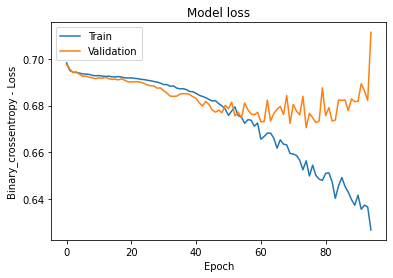

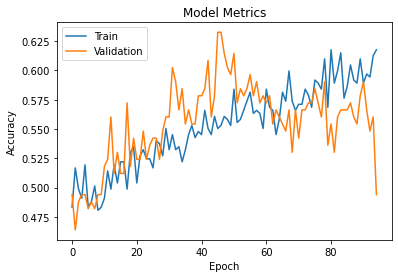

In [83]:

def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Binary_crossentropy - Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Metrics')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()
    
plot_loss(history)

In [84]:
model.metrics_names

['loss', 'accuracy']

In [85]:
y_pred = model.predict(X_test)
res = model.evaluate(X_test,y_test)
print(f'Loss on the test set : {res[0]:.8f}')
print(f'Accuracy on the test set : {res[1]:.8f}')

5/5 [==============================] - 0s 2ms/step - loss: 0.7721 - accuracy: 0.5942
Loss on the test set : 0.77206117
Accuracy on the test set : 0.59420288


## Unscale data

## Consecutive dates: not the case!!

Note: Consecutive value of y_test doesnt contain data from two consective dats(because of random smaple)

## Turn into classification task - TBD